https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  
https://www.kaggle.com/c/advanced-dls-spring-2021/  

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def print_correlation(data, threshold):
    corr = data.corr(method='pearson').abs()
    np.fill_diagonal(corr.values, np.nan)
    corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
    print(corr[corr > threshold])

def plot_correlation(data):
    plt.figure(figsize=(4,4))
    sns.heatmap(data.corr(method='pearson').abs(), square=True)

def plot_scatter(x, y, data):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=x, y=y, data=data)

In [4]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [5]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

In [932]:
print_correlation(data[num_cols], 0.6)

ClientPeriod     TotalSpent    0.826332
MonthlySpending  TotalSpent    0.652034
dtype: float64


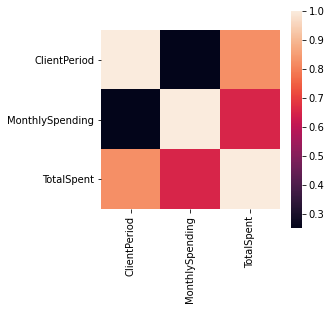

In [933]:
plot_correlation(data[num_cols])

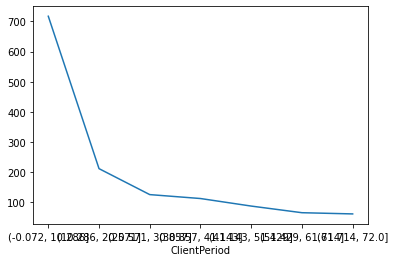

In [2239]:
data.groupby(pd.cut(data['ClientPeriod'], 7).astype(str))['Churn'].sum().plot();

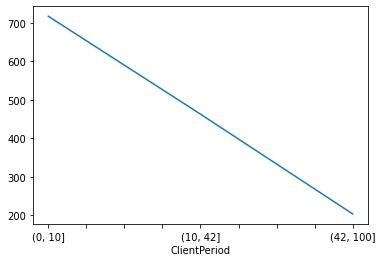

In [2344]:
data.groupby(pd.cut(data['ClientPeriod'], bins=[0,10,42,100]).astype(str))['Churn'].sum().plot();

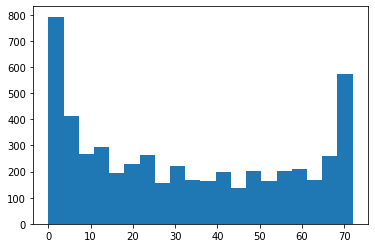

In [2542]:
plt.hist(data['ClientPeriod'], bins=20);

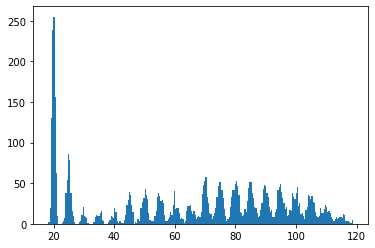

In [2463]:
# multimodal normal distribution
plt.hist(data['MonthlySpending'], bins=250);

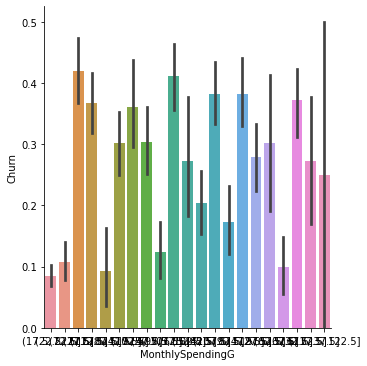

In [76]:
data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(-2.5,130,5)).astype(str)
sns.catplot(x="MonthlySpendingG", y="Churn", data=data, kind="bar");

<AxesSubplot:xlabel='MonthlySpendingG2'>

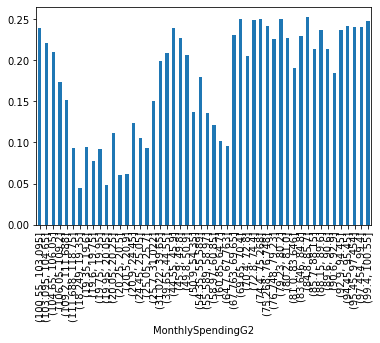

In [2526]:
train_data['MonthlySpendingG2'] = pd.qcut(data['MonthlySpending'], 50).astype(str)
train_data.groupby('MonthlySpendingG2')['Churn'].var().plot.bar()

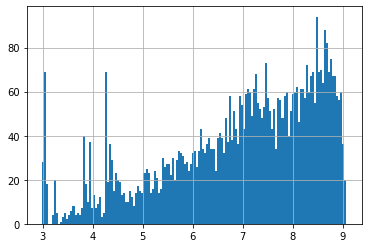

In [2431]:
np.log1p(data['TotalSpent']).hist(bins=150);

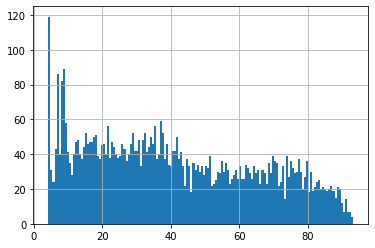

In [2450]:
np.sqrt(data['TotalSpent']).hist(bins=150);

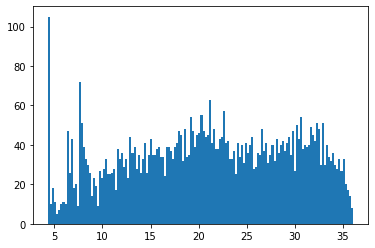

In [2451]:
plt.hist(stats.boxcox(data['TotalSpent'])[0], bins=150);

In [2410]:
np.arange(-2.5,130,5)

array([ -2.5,   2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,
        42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,
        87.5,  92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5])

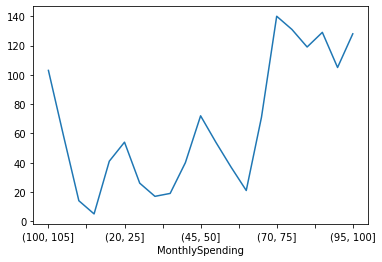

In [2382]:
data.groupby(pd.cut(data['MonthlySpending'], bins=np.arange(0,125,5)).astype(str))['Churn'].sum().plot();

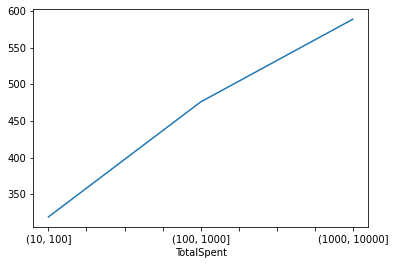

In [79]:
data.groupby(pd.cut(data['TotalSpent'], bins=[0,10,100,1000,10000]).astype(str))['Churn'].sum().plot();

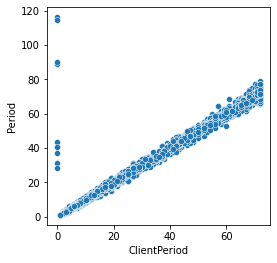

In [80]:
data['Period'] = data['TotalSpent'] / data['MonthlySpending']
plot_scatter('ClientPeriod', 'Period', data)

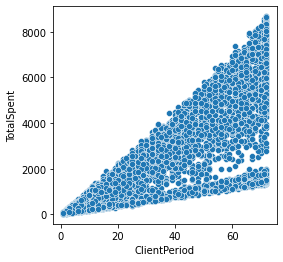

In [934]:
plot_scatter('ClientPeriod', 'TotalSpent', data)

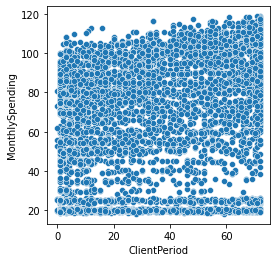

In [2172]:
plot_scatter('ClientPeriod', 'MonthlySpending', data)

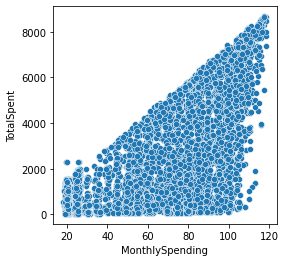

In [2174]:
plot_scatter('MonthlySpending', 'TotalSpent', data)

In [8]:
def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
    data[cat_cols] = data[cat_cols].fillna(data[num_cols].median()[0])
    data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 13).astype(str)
    # data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[0,10,42,100]).astype(str)
    # data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], 5).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(-2.5,130,5)).astype(str)
    data['TotalSpentG'] = pd.cut(data['TotalSpent'], 8).astype(str)
    data['ClientPeriodLog'] = np.log1p(data['ClientPeriod'])
    data['MonthlySpendingLog'] = np.log1p(data['MonthlySpending'])
    data['TotalSpentLog'] = np.log1p(data['TotalSpent'])
    data['TotalSpentCox'] = stats.boxcox(data['TotalSpent'])[0]
    return data

def predict_data(model, test_data):
    submission = pd.read_csv('./submission.csv')
    submission['Churn'] = model.predict_proba(test_data)[:,1]
    submission.to_csv('./my_submission.csv', index=False)

test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')
test_data = prepare_data(test_data)
train_data = prepare_data(train_data)

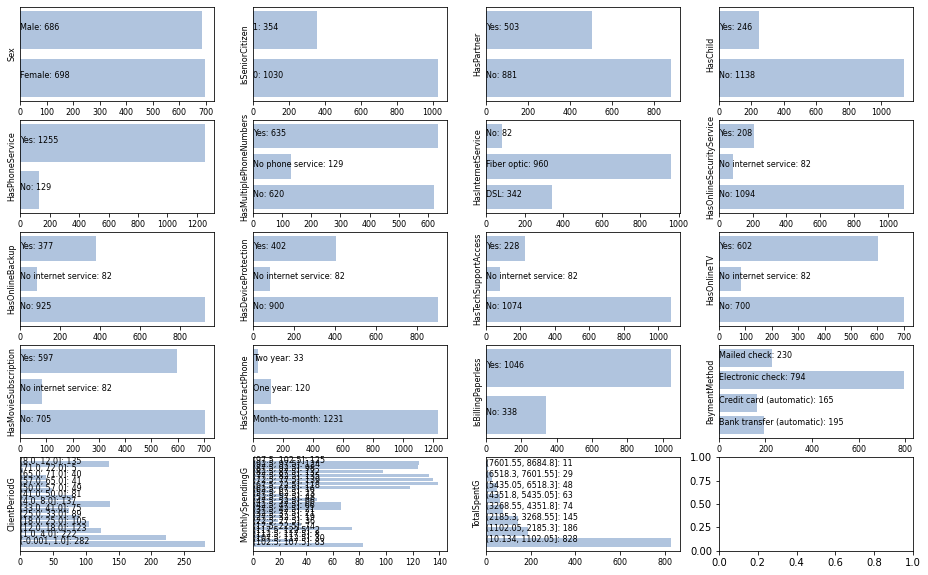

In [9]:
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
fig, axes = plt.subplots(5, 4, figsize=(16,10))
for c, ax in zip(cat_cols_, axes.flat):
    cnt = train_data.groupby(c)['Churn'].sum()
    ax.barh(cnt.index, cnt.values, color='lightsteelblue')
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(c, fontsize=8)
    ax.set_yticks([])
    z = zip(range(len(cnt)), cnt.index, cnt.values)
    for i, k, v in z: ax.text(0, i, f'{k}: {v}', fontsize=8)

In [10]:
num_cols_ = []
cat_cols_ = cat_cols + ['MonthlySpendingG','ClientPeriodG','TotalSpentG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols_), ('num', num_transformer, num_cols_)])

classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8482, 0.000152


In [2412]:
cat_cols_ = cat_cols + ['MonthlySpendingG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=100)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8284, 0.003999


In [ ]:
grid = {'clf__C':[1000, 100, 10, 1, 0.1], 'clf__penalty':['l1','l2']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=10)
cv.fit(data[cat_cols_], data[target_col])
cv.best_estimator_

In [965]:
model.fit(train_data[cat_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols_])

In [1863]:
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
catboost = CatBoostClassifier(learning_rate=0.1, num_trees=100)
catboost.set_params(cat_features=cat_cols_, silent=True)
s = cross_val_score(catboost, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8471, 0.000156


In [918]:
model.fit(train_data[cat_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols_])

In [1864]:
num_cols_ = ['ClientPeriod','MonthlySpending','TotalSpent']
catboost = CatBoostClassifier(learning_rate=0.1, num_trees=100)
catboost.set_params(cat_features=cat_cols, silent=True)
s = cross_val_score(catboost, train_data[cat_cols + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8476, 0.000130


In [1865]:
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = RandomForestClassifier(n_estimators=200, max_depth=10, criterion='entropy')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8387, 0.000169


In [1866]:
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = KNeighborsClassifier(n_neighbors=129, metric='euclidean')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8335, 0.000327


In [1867]:
num_cols_ = ['ClientPeriod','MonthlySpending','TotalSpent']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols)])
classifier = KNeighborsClassifier(n_neighbors=128, metric='minkowski')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}')

0.8190, 0.000410


In [890]:
model.fit(train_data[cat_cols + num_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols + num_cols_])

In [2143]:
data = pd.read_csv('./train.csv')
data = prepare_data(data)
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data[target_col])

cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

model.fit(train_data[cat_cols_], train_data[target_col])
roc_auc_score(test_data[target_col], model.predict_proba(test_data[cat_cols_])[:,1])
# f1_score(train_data[target_col], model.predict(train_data[cat_cols_]))
# accuracy_score(train_data[target_col], model.predict(train_data[cat_cols_]))

0.8513861890215682

In [49]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD # LSA

from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from umap import UMAP
from hdbscan import HDBSCAN

def scatter_2dim(X_projected, y, title):
    plt.figure(figsize=(8,5))
    plt.scatter(X_projected[:,0], X_projected[:,1], c=y)
    plt.title(title)
    plt.colorbar();

data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
data[cat_cols] = data[cat_cols].fillna(data[num_cols].median()[0])

data = pd.get_dummies(data, columns=cat_cols)
X, y = data[num_cols], data['Churn']

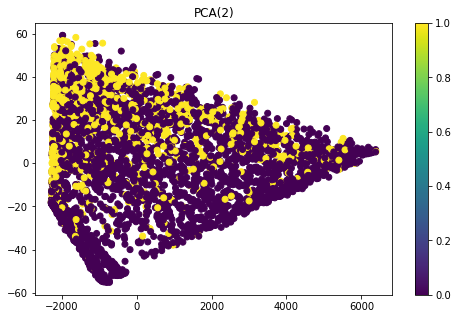

In [41]:
X_pca_2 = PCA(n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_pca_2, y, 'PCA(2)')

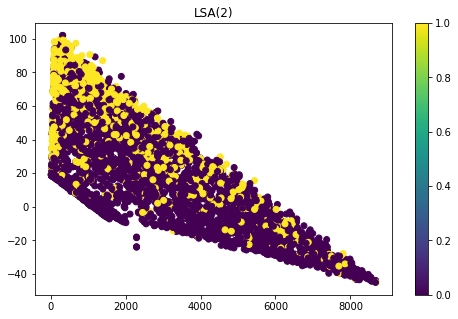

In [42]:
X_lsa_2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_lsa_2, y, 'LSA(2)')

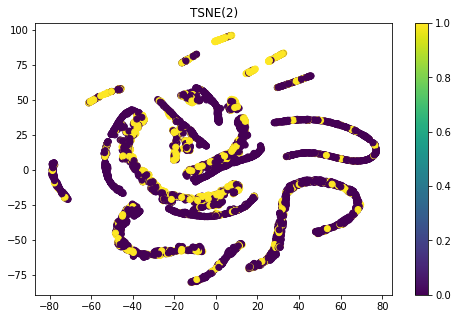

In [43]:
X_tsne_2 = TSNE(n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_tsne_2, y, 'TSNE(2)')

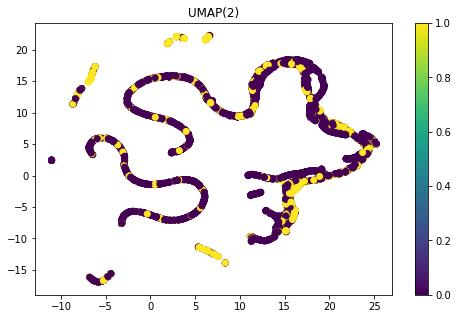

In [44]:
X_umap_2 = UMAP(n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_umap_2, y, 'UMAP(2)')

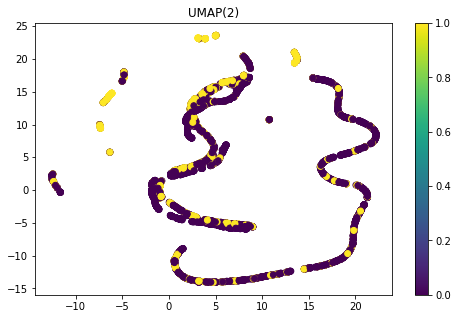

In [46]:
X_umap_2 = UMAP(n_neighbors=20, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_umap_2, y, 'UMAP(2)')

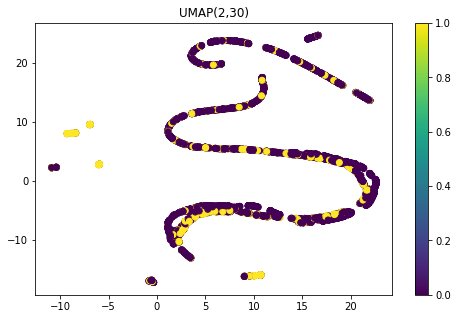

In [34]:
X_umap_2_30 = UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
scatter_2dim(X_umap_2_30, y, 'UMAP(2,30)')

In [75]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
data[cat_cols] = data[cat_cols].fillna(data[num_cols].median()[0])
data = pd.get_dummies(data, columns=cat_cols)
# X, y = data.drop('Churn', axis=1), data['Churn']
X, y = data[num_cols], data['Churn']

clusters = GaussianMixture(n_components=2, random_state=42).fit_predict(X)

p = np.zeros_like(clusters)
for c in range(2):
    if np.sum(clusters == c):
        p[clusters == c] = stats.mode(y[clusters == c])[0][0]

# scatter_2dim(X_gmm_2, y, 'GMM(2)')

(p == y).mean()

0.7379780386217342